# Draft

A jupyter notebook to test various small tasks. Each section can be run separately.

## Reading video from opencv

In [85]:
# importing opencv
import cv2

In [86]:
# testing reading video from opencv
cap = cv2.VideoCapture(0)

while cap.isOpened():
    # capture frame
    ret, frame = cap.read()
    
    # display frame
    cv2.imshow("Testing camera", frame)
    
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
    
# release the capture object
cap.release()
 
# Close frames
cv2.destroyAllWindows()

## Mediapipe hand landmarks detection on still image

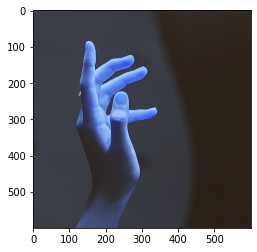

In [87]:
# Importing a test image
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./data/Hand_Model.jpg')
plt.imshow(img);

In [88]:
# Importing mediapipe modules
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [89]:
# creating a HandLandmarker object
base_options = python.BaseOptions(model_asset_path='./models/hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

In [90]:
# loading input image
image = mp.Image.create_from_file("./data/Hand_Model.jpg")

In [91]:
# detect landmarks from image
detection_result = detector.detect(image)

In [92]:
#Implementing a function to visualize the hand landmark detection results (from mediapipe guide)

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

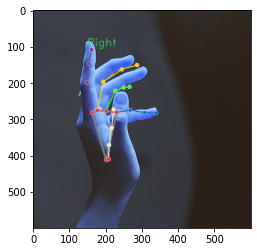

In [93]:
# Vizualize classification result
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

## Mediapipe hand landmarks detection on live video

Using detection + tracking

In [94]:
# importing opencv
import cv2

# importing mediapipe modules
import mediapipe as mp
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [95]:
# utility functions for inside the loop

def process_frame(frame, model):
    # convert frame to rgb
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # detect landmarks from image
    results = model.process(rgb_frame)
    return(results)

def annotate_frame(frame, results):
    if results.multi_hand_landmarks:
          for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

In [96]:
with mp_hands.Hands(max_num_hands = 2, min_detection_confidence = 0.5, min_tracking_confidence = 0.8) as hands:
    cap = cv2.VideoCapture(0)
    
    # setting up window size
    cv2.namedWindow("Annotated hands", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Annotated hands", 1000, 1000)
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # detect landmarks from image
        results = process_frame(frame, hands)
        
        # annotate the frame with landmarks
        annotate_frame(frame, results)
        
        # display frame
        cv2.imshow("Annotated hands", cv2.flip(frame, 1))
        
        # aiming for 25 fps
        if cv2.waitKey(40) & 0xFF == ord('q'):
            break
    
# release the capture object
cap.release()
 
# Close frames
cv2.destroyAllWindows()
        

## Saving landmarks

Hand detection + saving landmarks into a text file.

In [1]:
# importing opencv
import cv2

# importing numpy
import numpy as np

# importing mediapipe modules
import mediapipe as mp
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [5]:
# utility functions for inside the loop

def process_frame(frame, model):
    # convert frame to rgb
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # detect landmarks from image
    results = model.process(rgb_frame)
    return(results)

def annotate_frame(frame, results):
    mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                mp_drawing_styles.get_default_pose_landmarks_style())
    mp_drawing.draw_landmarks(frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing_styles.get_default_hand_landmarks_style(),
                                mp_drawing_styles.get_default_hand_connections_style())
    mp_drawing.draw_landmarks(frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing_styles.get_default_hand_landmarks_style(),
                                mp_drawing_styles.get_default_hand_connections_style())
    
def landmarks_to_array(results):
    out_array = np.concatenate(
            (np.array([(lm.x, lm.y, lm.z, lm.visibility) for lm in results.pose_landmarks.landmark[7:17]]
                if results.pose_landmarks
                    else np.zeros(40)).flatten(),
            np.array([(lm.x, lm.y, lm.z) for lm in results.left_hand_landmarks.landmark]
                if results.left_hand_landmarks
                 else np.zeros(63)).flatten(),
            np.array([(lm.x, lm.y, lm.z) for lm in results.right_hand_landmarks.landmark]
                if results.right_hand_landmarks
                 else np.zeros(63)).flatten())
    )
    return(out_array)

In [41]:
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.8) as hands:
    cap = cv2.VideoCapture(0)
    
    # setting up window size
    cv2.namedWindow("Annotated hands", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Annotated hands", 1000, 1000)
    n_frame = 1
    
    # setting up the np array 
    all_landmarks = None
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # detect landmarks from image
        results = process_frame(frame, hands)
        
        # annotate the frame with landmarks
        annotate_frame(frame, results)
        
        # display frame
        cv2.imshow("Annotated hands", cv2.flip(frame, 1))
        
        # wait 40 ms or break if 'q' is pressed
        if cv2.waitKey(40) & 0xFF == ord('q'):
            break
            
        # alternatively, break if we reach 75 frames
        #if n_frame > 75:
        #    break
        n_frame = n_frame + 1
    
        landmarks = landmarks_to_array(results)
        try:
            all_landmarks = np.vstack([all_landmarks, landmarks])
        except:
            all_landmarks = landmarks
        
# release the capture object
cap.release()
 
# Close frames
cv2.destroyAllWindows()

np.save('all_landmarks.npy', all_landmarks)

In [46]:
loaded_all_landmarks = np.load('all_landmarks.npy')

In [47]:
loaded_all_landmarks

array([[ 0.63000405,  0.35943139, -0.61845803, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.62988579,  0.35996452, -0.73263323, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.62958002,  0.36115393, -0.74827659, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.63185197,  0.38689554, -0.64050257, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.63175112,  0.3868168 , -0.64150596, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.63131285,  0.38667473, -0.63447016, ...,  0.        ,
         0.        ,  0.        ]])

In [48]:
loaded_all_landmarks.shape

(47, 166)

# Checking data properties

In [11]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
glosses_df = pd.read_csv('data/WSASL_100/WLASL_100.csv')
glosses_df.head()

,Unnamed: 0,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,gloss,file
0,0,"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,book,69241.mp4
1,10,"[462, 44, 949, 720]",25,-1,1,10,31,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,7069,book,07069.mp4
2,17,"[234, 17, 524, 414]",25,-1,1,17,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,7068,book,07068.mp4
3,22,"[131, 26, 526, 480]",25,-1,1,22,59,asldeafined,train,https://media.asldeafined.com/vocabulary/14666...,0,7070,book,07070.mp4
4,24,"[162, 54, 528, 400]",25,-1,1,24,12,aslsearch,val,http://www.aslsearch.com/signs/videos/book.mp4,0,7099,book,07099.mp4


In [14]:
# extracting frame_numbers
glosses_df['n_frames'] = np.zeros(glosses_df.shape[0])
for file in glosses_df.file:
    cap = cv2.VideoCapture('data/WSASL_100/videos/' + file)
    n = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    glosses_df['n_frames'][glosses_df.file == file] = n
    cap.release()

75.0
30.0
68.0
86.0
87.0
41.0
77.0
44.0
70.0
93.0
46.0
89.0
81.0


/tmp/ipykernel_304600/1006848514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glosses_df['n_frames'][glosses_df.file == file] = n


43.0
91.0
105.0
41.0
49.0
49.0
60.0
30.0
88.0
101.0
72.0
107.0
81.0
43.0
57.0
43.0
53.0
45.0
40.0
102.0
73.0
46.0
26.0
90.0
100.0
52.0
31.0
58.0
45.0
86.0
108.0
81.0
87.0
52.0
50.0
31.0
28.0
50.0
96.0
93.0
81.0
31.0
92.0
59.0
32.0
67.0
61.0
46.0
66.0
47.0
47.0
43.0
41.0
108.0
61.0
33.0
63.0
88.0
34.0
61.0
89.0
83.0
93.0
36.0
67.0
63.0
86.0
67.0
36.0
40.0
47.0
61.0
93.0
58.0
155.0
54.0
111.0
46.0
47.0
82.0
88.0
32.0
30.0
86.0
75.0
58.0
59.0
28.0
62.0
64.0
94.0
42.0
70.0
79.0
70.0
71.0
71.0
94.0
96.0
106.0
131.0
106.0
59.0
43.0
40.0
72.0
108.0
82.0
24.0
38.0
26.0
38.0
52.0
62.0
66.0
45.0
42.0
65.0
75.0
77.0
79.0
77.0
84.0
90.0
38.0
32.0
75.0
77.0
71.0
58.0
68.0
59.0
59.0
50.0
53.0
59.0
62.0
30.0
55.0
64.0
67.0
65.0
83.0
46.0
107.0
53.0
45.0
54.0
68.0
80.0
53.0
54.0
54.0
90.0
87.0
90.0
29.0
31.0
62.0
37.0
30.0
30.0
73.0
72.0
90.0
119.0
49.0
96.0
87.0
29.0
34.0
81.0
53.0
66.0
94.0
72.0
64.0
44.0
51.0
94.0
79.0
52.0
53.0
97.0
58.0
70.0
28.0
60.0
72.0
68.0
56.0
56.0
48.0
54.0
47.0
63.0
90.0


<AxesSubplot:xlabel='n_frames', ylabel='Count'>

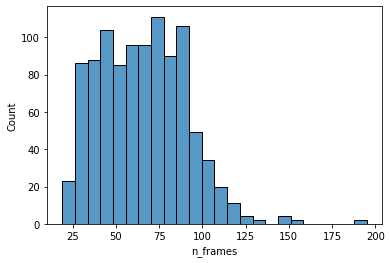

In [18]:
sns.histplot(glosses_df, x = 'n_frames')

<AxesSubplot:xlabel='gloss'>

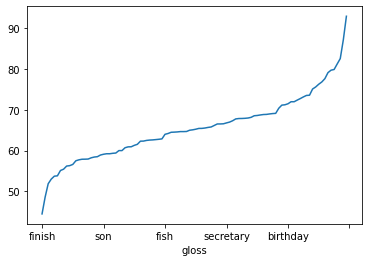

In [23]:
glosses_df.groupby('gloss').agg(np.mean)['n_frames'].sort_values().plot()

In [24]:
glosses_df.groupby('gloss').agg(np.mean)['n_frames']

gloss
accident      66.538462
africa        72.777778
all           79.750000
apple         81.272727
basketball    67.333333
                ...    
woman         60.000000
work          65.800000
wrong         58.500000
year          64.200000
yes           58.416667
Name: n_frames, Length: 100, dtype: float64

In [44]:
glosses_df[glosses_df.gloss == 'black']

,Unnamed: 0,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,gloss,file,n_frames
221,479,"[295, 38, 885, 720]",25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/black.mp4,0,69236,black,69236.mp4,63.0
222,482,"[205, 17, 524, 414]",25,-1,1,4,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,6472,black,06472.mp4,91.0
223,483,"[544, 60, 1618, 1080]",25,-1,1,5,4,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,6473,black,06473.mp4,56.0
224,484,"[77, 18, 515, 480]",25,-1,1,6,59,asldeafined,train,https://media.asldeafined.com/vocabulary/14666...,0,6474,black,06474.mp4,80.0
225,486,"[58, 15, 216, 192]",25,-1,1,8,11,signingsavvy,val,https://www.signingsavvy.com/signs/mp4/6/6787.mp4,0,6476,black,06476.mp4,33.0
226,487,"[48, 11, 226, 192]",25,-1,1,9,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/7/7145.mp4,0,6477,black,06477.mp4,24.0
227,488,"[63, 8, 245, 192]",25,-1,1,10,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/8/8384.mp4,0,6478,black,06478.mp4,45.0
228,490,"[149, 24, 479, 370]",25,-1,1,13,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65200,black,65200.mp4,47.0
229,491,"[66, 13, 258, 240]",25,-1,1,14,56,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/3...,0,6471,black,06471.mp4,77.0
230,498,"[131, 52, 555, 400]",25,-1,1,21,12,aslsearch,train,http://www.aslsearch.com/signs/videos/black.mp4,0,6486,black,06486.mp4,111.0


# Testing ML on 5 glosses

In [53]:
import numpy as np
import tensorflow as tf
import keras
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [54]:
## load npy_data:
features = []
labels = []
data_path = 'data/WSASL_100/landmarks_5/'
folders_list = os.listdir(data_path)
for folder in folders_list:
    files = os.listdir(data_path + folder)
    for file in files:
        features.append(np.load(data_path + folder + '/' + file))
        labels.append(folder)

In [55]:
# mapping labels to ints:
labels_map = {label:number for number, label in enumerate(np.unique(labels))}
mapped_labels = [labels_map[lab] for lab in labels]
mapped_labels = np.array(mapped_labels)
mapped_labels = to_categorical(mapped_labels).astype(int)

In [56]:
## padding features:
padded_features = keras.utils.pad_sequences(features, )
padded_features = np.array(padded_features)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(padded_features,
                                                    mapped_labels,
                                                    test_size = 0.1)

In [200]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [201]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(100,166)))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(32, return_sequences=False, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(len(np.unique(labels)), activation='softmax'))

In [202]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 100, 32)           25472     
                                                                 
 lstm_32 (LSTM)              (None, 100, 64)           24832     
                                                                 
 lstm_33 (LSTM)              (None, 32)                12416     
                                                                 
 dense_31 (Dense)            (None, 32)                1056      
                                                                 
 dense_32 (Dense)            (None, 16)                528       
                                                                 
 dense_33 (Dense)            (None, 5)                 85        
                                                                 
Total params: 64389 (251.52 KB)
Trainable params: 643

In [203]:
initial_learning_rate = 10**-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.95,
    staircase=False)

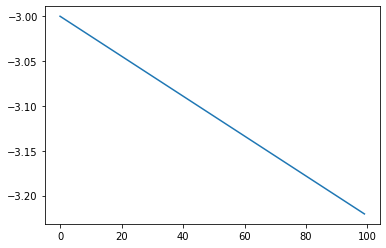

In [204]:
epoch = [i for i in range(100)]
lr = [lr_schedule(ep) for ep in epoch]
plt.plot(epoch, np.log10(lr))

In [205]:
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [206]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.3)

Epoch 1/100
12/12 [==============================] - 7s 170ms/step - loss: 1.6038 - categorical_accuracy: 0.2814 - val_loss: 1.5983 - val_categorical_accuracy: 0.2975
Epoch 2/100
12/12 [==============================] - 1s 115ms/step - loss: 1.5818 - categorical_accuracy: 0.2951 - val_loss: 1.5699 - val_categorical_accuracy: 0.2975
Epoch 3/100
12/12 [==============================] - 1s 115ms/step - loss: 1.6044 - categorical_accuracy: 0.2814 - val_loss: 1.5513 - val_categorical_accuracy: 0.2975
Epoch 4/100
12/12 [==============================] - 1s 118ms/step - loss: 1.5371 - categorical_accuracy: 0.2951 - val_loss: 1.5552 - val_categorical_accuracy: 0.2975
Epoch 5/100
12/12 [==============================] - 1s 118ms/step - loss: 1.5383 - categorical_accuracy: 0.2951 - val_loss: 1.5465 - val_categorical_accuracy: 0.2975
Epoch 6/100
12/12 [==============================] - 1s 116ms/step - loss: 1.5253 - categorical_accuracy: 0.2951 - val_loss: 1.5359 - val_categorical_accuracy: 0.297

Epoch 50/100
12/12 [==============================] - 2s 147ms/step - loss: 1.3826 - categorical_accuracy: 0.3607 - val_loss: 1.5285 - val_categorical_accuracy: 0.2722
Epoch 51/100
12/12 [==============================] - 1s 124ms/step - loss: 1.3821 - categorical_accuracy: 0.3552 - val_loss: 1.5318 - val_categorical_accuracy: 0.2785
Epoch 52/100
12/12 [==============================] - 1s 125ms/step - loss: 1.3816 - categorical_accuracy: 0.3525 - val_loss: 1.5350 - val_categorical_accuracy: 0.2785
Epoch 53/100
12/12 [==============================] - 1s 123ms/step - loss: 1.3812 - categorical_accuracy: 0.3443 - val_loss: 1.5377 - val_categorical_accuracy: 0.2785
Epoch 54/100
12/12 [==============================] - 1s 122ms/step - loss: 1.3807 - categorical_accuracy: 0.3415 - val_loss: 1.5411 - val_categorical_accuracy: 0.2785
Epoch 55/100
12/12 [==============================] - 1s 122ms/step - loss: 1.3804 - categorical_accuracy: 0.3415 - val_loss: 1.5458 - val_categorical_accuracy:

Epoch 99/100
12/12 [==============================] - 1s 119ms/step - loss: 1.3731 - categorical_accuracy: 0.3415 - val_loss: 1.6445 - val_categorical_accuracy: 0.2468
Epoch 100/100
12/12 [==============================] - 1s 117ms/step - loss: 1.3730 - categorical_accuracy: 0.3415 - val_loss: 1.6445 - val_categorical_accuracy: 0.2468


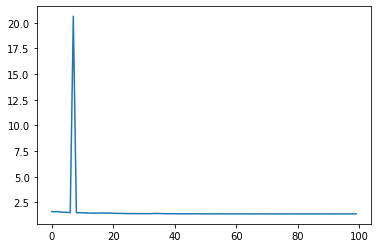

In [207]:
plt.plot(history.history['loss'])

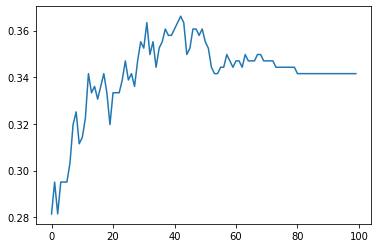

In [208]:
plt.plot(history.history['categorical_accuracy'])

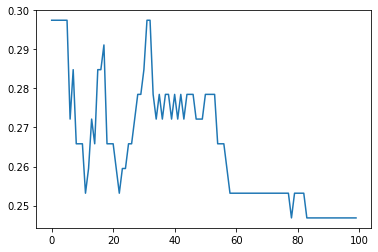

In [209]:
plt.plot(history.history['val_categorical_accuracy'])

In [210]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 100, 32)           25472     
                                                                 
 lstm_32 (LSTM)              (None, 100, 64)           24832     
                                                                 
 lstm_33 (LSTM)              (None, 32)                12416     
                                                                 
 dense_31 (Dense)            (None, 32)                1056      
                                                                 
 dense_32 (Dense)            (None, 16)                528       
                                                                 
 dense_33 (Dense)            (None, 5)                 85        
                                                                 
Total params: 64389 (251.52 KB)
Trainable params: 643

In [211]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 34ms/step - loss: 4.8554 - categorical_accuracy: 0.2881


[4.855449199676514, 0.2881355881690979]

# Testing ML on 5 glosses, single frame

In [1]:
import numpy as np
import tensorflow as tf
import keras
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt

2023-08-16 11:58:35.474329: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-16 11:58:35.524263: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-16 11:58:35.524958: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 11:58:36.280788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
## load npy_data:
features = []
labels = []
data_path = 'data/WSASL_100/landmarks_5/'
folders_list = os.listdir(data_path)
for folder in folders_list:
    files = os.listdir(data_path + folder)
    for file in files:
        # loading data by frame
        to_append = [frame_data for frame_data in np.load(data_path + folder + '/' + file)]
        features = features + to_append
        labels = labels + np.repeat(folder, len(to_append)).tolist()

In [3]:
# mapping labels to ints:
labels_map = {label:number for number, label in enumerate(np.unique(labels))}
mapped_labels = [labels_map[lab] for lab in labels]
mapped_labels = np.array(mapped_labels)
mapped_labels = to_categorical(mapped_labels).astype(int)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features),
                                                    mapped_labels,
                                                    test_size = 0.2)

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [6]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(None, 166)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(len(np.unique(labels)), activation='softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 16)          2672      
                                                                 
 dense_1 (Dense)             (None, None, 32)          544       
                                                                 
 dense_2 (Dense)             (None, None, 16)          528       
                                                                 
 dense_3 (Dense)             (None, None, 5)           85        
                                                                 
Total params: 3829 (14.96 KB)
Trainable params: 3829 (14.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
model.compile(optimizer=Adam(learning_rate=10**-3),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=900, validation_split=0.3)

Epoch 1/900
564/564 [==============================] - 1s 2ms/step - loss: 1.4425 - categorical_accuracy: 0.3535 - val_loss: 1.3580 - val_categorical_accuracy: 0.4094
Epoch 2/900
564/564 [==============================] - 1s 1ms/step - loss: 1.3012 - categorical_accuracy: 0.4330 - val_loss: 1.2387 - val_categorical_accuracy: 0.4719
Epoch 3/900
564/564 [==============================] - 1s 1ms/step - loss: 1.2068 - categorical_accuracy: 0.4884 - val_loss: 1.1660 - val_categorical_accuracy: 0.5003
Epoch 4/900
564/564 [==============================] - 1s 2ms/step - loss: 1.1381 - categorical_accuracy: 0.5168 - val_loss: 1.0994 - val_categorical_accuracy: 0.5460
Epoch 5/900
564/564 [==============================] - 1s 1ms/step - loss: 1.0810 - categorical_accuracy: 0.5413 - val_loss: 1.0560 - val_categorical_accuracy: 0.5597
Epoch 6/900
564/564 [==============================] - 1s 2ms/step - loss: 1.0414 - categorical_accuracy: 0.5542 - val_loss: 1.0280 - val_categorical_accuracy: 0.564

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

In [ ]:
model.evaluate(X_test, y_test)

# Testing an svm on 5 glosses, single frame

In [78]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [107]:
## load npy_data:
features = []
labels = []
data_path = 'data/WSASL_100/landmarks_5/'
folders_list = os.listdir(data_path)
for folder in folders_list:
    files = os.listdir(data_path + folder)
    for file in files:
        # loading data by frame
        to_append = [frame_data for frame_data in np.load(data_path + folder + '/' + file)]
        features = features + to_append
        labels = labels + np.repeat(folder, len(to_append)).tolist()

In [108]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size = 0.2)

In [109]:
model = SVC(kernel='rbf', C=0.1)

In [110]:
model.fit(X_train, y_train)

SVC(C=0.1)

In [112]:
model.score(X_test, y_test)

0.478739913097455

583